In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from importlib import reload
from scipy.integrate import solve_ivp
import math



params = {
    'PI' : np.pi,
    'ALPHA' : 0.1,
    'a' : 3,
    'k' : 2,
    'h' : 81,
    'r0' : 1.5,
    'R' : 57.5,
    'RHO' : 1.225,
    'ZETA' : 0.6,
    'ZETA2' : 0.45,
    'ZETA3' : 0.9,
    'OMEGAn' : 11.11,
    'OMEGAn2' : 5.73,
    'OMEGAn3' : 3.42,
    'Bdt' : 755.49,
    'Kdt' : 2.7*1e9,
    'Jr' : 55*1e6,
    'Jg' : 55*1e6,
    'LAMBDAo' : 7.6,
    'CPmax' : 0.486,
    'Area' :  math.pi * (57.5**2),
}

path = r'Datasets/WindSpeed_V1.csv'
df = pd.read_csv(path)  
v = df.iloc[:,0].values + 1
v = np.sqrt(np.flip(v) )*4

In [2]:
class WindShearModel:
    def __init__(self, **params):

        self.PI = params['PI'] 
        self.ALPHA = params['ALPHA'] 
        self.h = params['h'] 
        self.r0 = params['r0'] 
        self.R = params['R'] 
        self.RHO = params['RHO'] 
        self.ZETA = params['ZETA'] 
        self.ZETA2 = params['ZETA2'] 
        self.ZETA3 = params['ZETA3'] 
        self.OMEGAn = params['OMEGAn'] 
        self.OMEGAn2 = params['OMEGAn2'] 
        self.OMEGAn3 = params['OMEGAn3'] 

    def Vws(self, THETA, Vm=10):
        R = self.R
        r0 = self.r0
        ALPHA = self.ALPHA
        h = self.h
        THETAS = [THETA, THETA + (2*self.PI/3), THETA + (4*self.PI/3)]
        Xs = [np.cos(THETAS[i]) for i in range(len(THETAS))]
        vws = np.array([])
        for X in Xs:
            p1 = (2*Vm/(3*R**2)) * ((ALPHA*X*R**3/(3*h)) + ((R**4)*ALPHA*(ALPHA-1)*(X**2)/(4*2*(h**2))))
            p2 = (2*Vm/(3*R**2)) * ((R**5)*((ALPHA**2)-ALPHA)*(ALPHA-2)*(X**3)/(5*6*h**3))
            v = p1 + p2
            vws = np.append(vws,v)
        return vws

In [3]:
wsm = WindShearModel(**params)
angs = np.linspace(0,np.pi*2,100)
vws_ = []
for ang in angs:
    vws = wsm.Vws(THETA=ang)
    vws_.append(vws)
vws_ = np.array(vws_).T

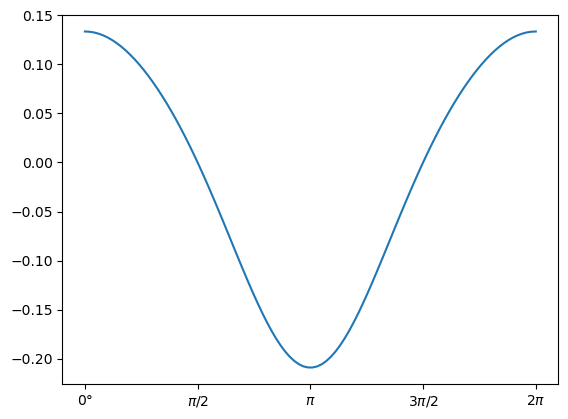

In [4]:
""" for v in vws_:
    plt.plot(angs,v)
 """
plt.plot(angs,vws_[0])
radian_ticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
degree_labels = ['0°', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']

plt.xticks(radian_ticks, degree_labels)
plt.show()

In [5]:
class TowerShadowModel:
    def __init__(self, **params):

        self.PI = params['PI'] 
        self.ALPHA = params['ALPHA'] 
        self.h = params['h'] 
        self.r0 = params['r0'] 
        self.R = params['R'] 
        self.a = params['a'] 
        self.k = params['k'] 
        self.RHO = params['RHO'] 
        self.ZETA = params['ZETA'] 
        self.ZETA2 = params['ZETA2'] 
        self.ZETA3 = params['ZETA3'] 
        self.OMEGAn = params['OMEGAn'] 
        self.OMEGAn2 = params['OMEGAn2'] 
        self.OMEGAn3 = params['OMEGAn3'] 

    def VTS(self, ang, Vm=1):
        R = self.R
        a = self.a
        k = self.k
        r0 = self.r0
        ALPHA = self.ALPHA
        h = self.h

        PSIs = [ang, ang + (2*self.PI/3), ang + (4*self.PI/3)]
        Xs = [np.sin(PSIs[i]) for i in range(len(PSIs))]
        m = 1 + (ALPHA*(ALPHA-1)*(R**2))/((8*(h**2)))
        q = 1 - ((r0/R)**2)
        
        vts = np.array([])
        for X in Xs:
            if X == 0:  X=1e-10
            p1 = (2*m*Vm)/(3*q*(R**2))
            p2 = (a**2)*np.log((R**2)*(X**2)+(k**2))/(2*(X**2))
            p3 = (a**2)*np.log((r0**2)*(X**2)+(k**2))/(2*(X**2))
            p4 = ((a**2)*(k**2))/((X**2)*((R**2)*(X**2)+(k**2)))
            p5 = ((a**2)*(k**2))/((X**2)*((r0**2)*(X**2)+(k**2)))
            #print('p1:',p1,'p2:',p2,'p3:',p3,'p4:',p4,'p5:',p5)
            v = p1*(p2-p3+p4-p5)
            vts = np.append(vts,v)
        return vts

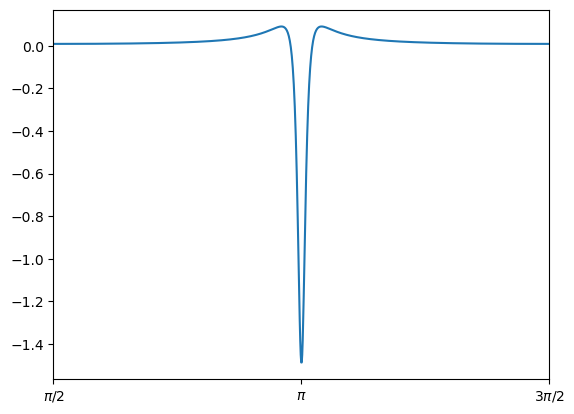

In [6]:
TSM = TowerShadowModel(**params)
angs = np.linspace(0,np.pi*2,2000)
vts_ = []
for ang in angs:
    vts = TSM.VTS(ang=ang, Vm=2)
    vts_.append(vts)
vts_ = np.array(vts_).T

plt.plot(angs,vts_[0])
radian_ticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
degree_labels = ['0°', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']
plt.xticks(radian_ticks, degree_labels)
plt.xlim(np.pi/2,3*np.pi/2)
plt.show()

In [7]:
def Cp_calc(lmbd_in=0):
    path = r'Datasets/Cp_X_lambda.csv'
    df = pd.read_csv(path)
    dist = np.abs(df['lambda'].values - lmbd_in)

    return (df['cp'].values[np.argmin(dist)])

class DriveTrain:
    def __init__(self, **params):

        self.RHO = params['RHO'] 
        self.R = params['R']
        self.Area = params['Area'] 
        self.Bdt = params['Bdt']
        self.Kdt = params['Kdt']
        self.Jr = params['Jr']
        self.Jg = params['Jg']
        self.lmbd_opt = params['LAMBDAo']
        self.Cp_star = params['CPmax']
        self.X = np.array([0,0,0])
        self.dX = np.array([0,0,0])
        self.U = np.array([0,0])
        self.PD = np.array([0])
        self.PG = np.array([0])
        self.ED = np.array([0])
        self.EG = np.array([0])
        self.K_mppt = np.array([[0]])
        self.X_ = np.array([[0,0,0]])
        self.dX_ = np.array([[0,0,0]])
        self.Wr = np.array([])
        self.dWr = np.array([])
        self.k = 1
        self.cp_=[]
        self.lmbd_=[]

    def set_state(self, X):
        """
        Define the current state of the plant. 
        
        x : array-like
            Current state [omega_r, omega_g, theta]
        """
        self.X = X.flatten()

    def dynamics(self, t, X, U):


        Bdt = self.Bdt 
        Kdt = self.Kdt 
        Jr = self.Jr 
        Jg = self.Jg 
        
        A=np.array([[-Bdt/Jr,  Bdt/Jr, -Kdt/Jr],
                    [ Bdt/Jg, -Bdt/Jg,  Kdt/Jg],
                    [    1,    -1,     0]])
        
        B = np.array([[1/Jr,      0],
                      [    0, -1/Jg],
                      [    0,     0]])
        
        dX = (A@X.reshape(-1,1))+(B@U.reshape(-1,1))
        self.dX = dX.flatten()
        return dX.flatten()
    
    def compute_input(self, v, X, uk=0):
        """
        Compute control input u as u = Kx + uf, where
        uf is a feedforward term.
        
        Parameters:
        x: numpy array
            Current state [x, y, theta, vx, vy, w]
        K: numpu array matrix-alike
            Gain matrix.
        """
        
        wr = X[0]
        wg = X[1]
        rho = self.RHO
        A = self.Area
        R = self.R
        lmbd_star = self.lmbd_opt + uk
        lmbd = wr*R/v
        Cp_star = self.Cp_star
        if lmbd_star != self.lmbd_opt:
            Cp_star = Cp_calc(lmbd_star)
        Cp = Cp_calc(lmbd)
        self.cp_.append(Cp_star)
        self.lmbd_.append(lmbd_star)
        K_mppt = 0.5 * rho * A * (R**3) * Cp_star/(lmbd_star**3)
        #print(lmbd_star,Cp_star,K_mppt)
        tR = 0.5*rho*A*Cp*(v**3)/wr
        tG = K_mppt*(wg**2)
        du = np.array([tR,tG])
        self.U = du
        self.K_mppt = np.append(self.K_mppt,K_mppt)
        
        return du
    
    def iterate(self, u, dt):
        """
        Propagate the system forward in time by 'dt' using 
        numerical integration.
        
        Parameters:
        u : array-like
            Input vector [u1, u2]
        dt : float
            Time step
        """
        #DOP853
        sol = solve_ivp(self.dynamics, [0, dt], self.X, 
            args=(u.flatten(),), method="DOP853", t_eval=[dt])
        self.X = sol.y[:, -1]
        return self.X
    
    def compute_output(self):
        X = self.X.reshape(1,-1)
        dX = self.dX.reshape(1,-1)
        B = self.Bdt
        tau_r, tau_g = self.U
        Wr, Wg, _ = self.X
        dWr, dWg, _ = self.dX
        PG = tau_g*Wg
        PD = B*((Wr-Wg)**2)

        self.Wr = np.append(self.Wr,Wr)
        self.dWr = np.append(self.dWr,dWr)
        #if self.k>=300:
        EG = self.EG[-1]+PG
        ED = self.ED[-1]+PD

        self.PD = np.append(self.PD,PD)
        self.PG = np.append(self.PG,PG) 
        self.ED = np.append(self.ED,ED)
        self.EG = np.append(self.EG,EG) 
        self.X_ = np.append(self.X_,X,axis=0)  
        self.dX_ = np.append(self.dX_,dX,axis=0)  
        if self.k == 1:
            self.PD = np.delete(self.PD,0)
            self.PG = np.delete(self.PG,0) 
            self.ED = np.delete(self.ED,0)
            self.EG = np.delete(self.EG,0) 

        self.k = self.k + 1



In [8]:
""" dTrain = DriveTrain(**params)
X=np.array([1,1,0])
for i in range(len(v[:5000])):
    U = dTrain.compute_input(v[i],X,uk=0)
    X = dTrain.iterate(U,1)
    dTrain.compute_output() """

' dTrain = DriveTrain(**params)\nX=np.array([1,1,0])\nfor i in range(len(v[:5000])):\n    U = dTrain.compute_input(v[i],X,uk=0)\n    X = dTrain.iterate(U,1)\n    dTrain.compute_output() '

In [9]:
WRs = (dTrain.Wr)
THETAs = np.array([0])

for WR in WRs:
    THETAf = THETAs[-1]+WR
    THETAs = np.append(THETAs,THETAf)

NameError: name 'dTrain' is not defined

In [ ]:
THETAs2 = np.array([])
for val in THETAs:
    THETAf = math.degrees(val*180/np.pi) % 360
    THETAs2 = np.append(THETAs2,THETAf)

#SIMULAR ROTAÇÃO CONSTANTE

In [10]:
WR = (2*np.pi)/60
time = np.linspace(0,3600,3601)
THT = []
for t in time:
    if len(THT)<1: 
        val=0
    else:
        val = THT[-1]+WR
    THT.append(val % (2*np.pi))
THT = np.array(THT)

In [11]:
wsm = WindShearModel(**params)
vws_ = []
for v_,THT_ in zip(THT,v):
    vws = wsm.Vws(THETA=THT_, Vm=20)
    vws_.append(vws)
vws_ = np.array(vws_).T

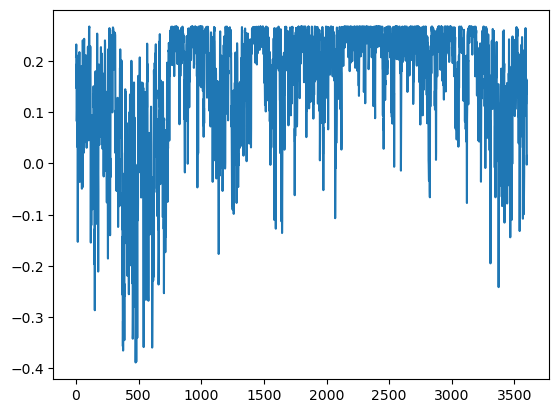

In [12]:
plt.plot(time, vws_[0])

In [ ]:
wsm = WindShearModel(**params)
angs = np.linspace(0,np.pi*2,100)
vws_ = []
for ang in angs:
    vws = wsm.Vws(THETA=ang)
    vws_.append(vws)
vws_ = np.array(vws_).T